In [11]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec

### Build basis and Hamiltonian

In [2]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
Nsites = 4
Nbosons = 2
###### parameters
L_spin = Nsites-1
L_modes = Nsites # system size
cutoff = Nbosons+1 #sites+2
h = 1 # field strength
t = 1
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes,sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)
# print(basis)

##### create model


### define initial state

In [3]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'

def isodd(n):
    return int(n)%2 == True

def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)

def gaugeFixedBasis(Nsites,Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons+1)**Nsites):
        bosonString = np.base_repr(number, base=Nbosons+1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    print(bosonStates)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state)-1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0: # For the first site
                thislink = '-'*(isodd(thisn)) + '+'*(not isodd(thisn))
            else: # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates
# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c,Nbosons):
    return basis(Nbosons+1,int(c))

def linkState(c):
    if c == '+':
        return (basis(2,0) + basis(2,1)).unit()
    elif c == '-':
        return (basis(2,0) - basis(2,1)).unit()

basisStatesList = gaugeFixedBasis(Nsites,Nbosons)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList: # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)): # Loop through each site/link from left to right
        c = state[ind]
        if isodd(ind):
            basisVector.append(linkState(c))
        else:
            basisVector.append(siteState(c,Nbosons))
    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis),i)*fullBasis[i].dag()

P = P_gaugefixed.full()
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes, sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)
##### create model
field = [[-h,i] for i in range(L_spin)]
density = [[0.1,i,i] for i in range(L_modes)]
static=[["x|",field],["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H1 = hamiltonian(static,[],basis=basis,**no_checks)

H1=H1.todense()

# print(H1.shape)

Hgaugefixed=np.dot(P,np.dot(H1,P.T.conj()))
Hsparse = sparse.csr_matrix(Hgaugefixed)
_,psi = eigsh(Hsparse,k=1)
psi=np.dot(P.T.conj(),psi)

['0002', '0011', '0020', '0101', '0110', '0200', '1001', '1010', '1100', '2000']


In [3]:
# ##### define initial state #####
# #Spin - find index of spin state |01>
# ispin = basis_spin.index("01")
# #Boson - find index of Fock state |20>
# iboson = basis_boson.index("02")
# # Ns is the size of the Hilbert space
# psispin = np.zeros(basis_spin.Ns,dtype=np.float64) # for 2 bosons in 2 modes Ns=3 ("20","11","02")
# psispin[ispin] = 1.0
# psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
# psiboson[iboson] = 1.0
# psi=np.kron(psispin,psiboson)

defining via product state (not in use)

In [4]:
##### define initial state #####
psispin=(1/np.sqrt(2))*np.array([1,1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("11a")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
psiboson[iboson] = 1.0
psi=np.kron(psispin,psiboson)

##### Check state we just made (not in use)

In [5]:
field = [[1.0,0]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static=[["z|",field]] #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_check = hamiltonian(static,[],basis=basis,**no_checks)
print(np.dot(psi.conj().T,H_check.dot(psi)))

0j


### Time evolve

get real groundstate

In [13]:
hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
density = [[0.01,i,i] for i in range(L_modes)]
field = [[-h,i] for i in range(L_spin)]
# static=[["z|+-",hop],["z|-+",hop],["x|",field]]
static=[["z|+-",hop],["z|-+",hop],["x|",field],["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H1 = hamiltonian(static,[],basis=basis,**no_checks)

H1=H1.todense()

# print(H1.shape)

Hgaugefixed=np.dot(P,np.dot(H1,P.T.conj()))
Hsparse = sparse.csr_matrix(Hgaugefixed)
_,psi1 = eigsh(Hsparse,k=1)
psi1=np.dot(P.T.conj(),psi1)[:,0]

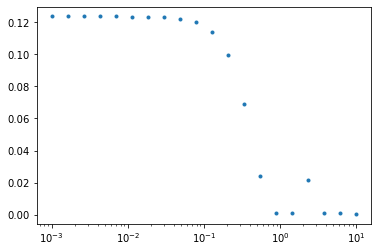

In [12]:
##### create model
def drive(t,t_0):
    return t/t_0
res=[]
t0s=np.logspace(-3,1,20)
for t0 in t0s:
    drive_args=[t0]
    hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
    density = [[0.01,i,i] for i in range(L_modes)]
    field = [[-h,i] for i in range(L_spin)]
    # static=[["z|+-",hop],["z|-+",hop],["x|",field]]
    static=[["x|",field],["|nn",density]]
    dynamic = [["z|+-",hop,drive,drive_args],["z|-+",hop,drive,drive_args]]
    ###### setting up operators
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,dynamic,basis=basis,**no_checks)

    psi_t=H.evolve(psi,0.0,[t0],iterate=False,rtol=1E-9,atol=1E-9)
    # calculate fidelity
    res.append(np.abs(np.dot(psi_t[:,0,0].conj(),psi1))**2)
plt.plot(t0s,res,'.')
plt.xscale('log')

plot occupations (not in use)

In [13]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi_t,t,{"n":n})
O_n = Obs_t["n"]

/tmp/ipykernel_5197/4003040525.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)


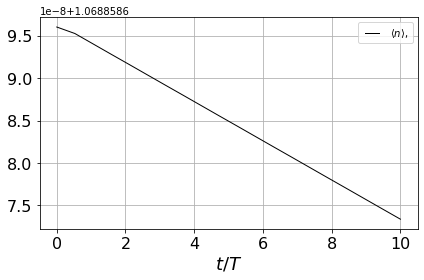

In [11]:
##### plot results #####
import matplotlib.pyplot as plt
import pylab
str_n = "$\\langle n\\rangle,$"
fig = plt.figure()
plt.plot(t,np.real(O_n),"k",linewidth=1,label=str_n)
plt.xlabel("$t/T$",fontsize=18)
# plt.ylim([-1.1,1.4])
plt.legend(loc="upper right",ncol=5,columnspacing=0.6,numpoints=4)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.tight_layout()
#plt.savefig('example3.pdf', bbox_inches='tight')
plt.show()
# plt.close()